## Music Evaluation

In [2]:
import json
from argparse import ArgumentParser
import midi
import glob
import copy
import os
import numpy as np
import pretty_midi
from pprint import pprint
import pickle
from mgeval.mgeval import core, utils
from sklearn.model_selection import LeaveOneOut

In [7]:
# midi file이 들어있는 folder path를 넣어주세요!

# dataset
classic = '/home/bang/다운로드/maestro-v2.0.0-midi/maestro_midi'
pop = '/home/bang/PycharmProjects/POP909-Dataset/pop909_midi'

'''
ToDo
1. Classic, pop real data VS MT_model
2. MT_model VS MT_only
3. MT_only VS CTRL_model
'''

# MT_model
#    classic : (classic + pop) training + classic primer + no condition token
#    pop     : (classic + pop) training + pop primer + no condition token
MT_classic = '/home/bang/PycharmProjects/MusicTransformer-Pytorch/static_midi_and_img/MT_classic_pop_none/classic'
MT_pop = '/home/bang/PycharmProjects/MusicTransformer-Pytorch/static_midi_and_img/MT_classic_pop_none/pop'

# only_model
#   classic only : classic training + classic primer
#   pop only     : pop training + pop primer
MT_classic_only = '/home/bang/PycharmProjects/MusicTransformer-Pytorch/static_midi_and_img/MT_classic_none/classic'
MT_pop_only = '/home/bang/PycharmProjects/MusicTransformer-Pytorch/static_midi_and_img/MT_pop_none/pop'

# CTRL
#    classic (condition) : classic + pop training + classic condition token + classic primer
#    pop (condition)     : classic + pop training + pop condition token + pop primer
MT_CTRL_classic1 = '/home/bang/PycharmProjects/MusicTransformer-Pytorch/static_midi_and_img/COMT/default_token/classic'
MT_CTRL_classic2 = '/home/bang/PycharmProjects/MusicTransformer-Pytorch/static_midi_and_img/COMT/reverse_token/pop'
MT_CTRL_pop1 = '/home/bang/PycharmProjects/MusicTransformer-Pytorch/static_midi_and_img/COMT/default_token/pop'
MT_CTRL_pop2 = '/home/bang/PycharmProjects/MusicTransformer-Pytorch/static_midi_and_img/COMT/reverse_token/classic'

# Octave
MT_octave_classic = '/home/bang/PycharmProjects/MusicTransformer-Pytorch/static_midi_and_img/result_octave_classic/classic'

# Octave absolute
MT_octave_absolute = '/home/bang/PycharmProjects/MusicTransformer-Pytorch/static_midi_and_img/result_absolute_classic/classic'


In [43]:
set1 = glob.glob(os.path.join(classic, '*'))
set2 = glob.glob(os.path.join(pop, '*'))

set3 = glob.glob(os.path.join(MT_classic, '*'))
set4 = glob.glob(os.path.join(MT_classic_only, '*'))

set5 = glob.glob(os.path.join(MT_octave_classic, '*'))# + glob.glob(os.path.join(MT_CTRL_classic2, '*'))
set6 = glob.glob(os.path.join(MT_octave_absolute, '*'))# + glob.glob(os.path.join(MT_CTRL_pop2, '*'))

## Number of samples

- set1: classic midi files
- set2: pop midi files

In [44]:
print("set1 size :", len(set3), ", set2 size :", len(set4))

set1 size : 1282 , set2 size : 1282


In [45]:
num_samples = min(len(set2), len(set3))

## metrics

- total used pitch
- pitch_range
- avg pitch shift
- avg IOI
- total_pitch class histogram

In [46]:
evalset = { 
            'total_used_pitch': np.zeros((num_samples, 1))
          , 'pitch_range': np.zeros((num_samples, 1))
          , 'avg_pitch_shift': np.zeros((num_samples, 1))
          , 'avg_IOI': np.zeros((num_samples, 1))
          , 'pitch_MAX':np.zeros((num_samples, 1))
          , 'pitch_MIN':np.zeros((num_samples, 1))
          #, 'total_used_note': np.zeros((num_samples, 1))
          # , 'bar_used_pitch': np.zeros((num_samples, args.num_bar, 1))
          # , 'bar_used_note': np.zeros((num_samples, args.num_bar, 1))
          , 'total_pitch_class_histogram': np.zeros((num_samples, 12))
          # , 'bar_pitch_class_histogram': np.zeros((num_samples, args.num_bar, 12))
          , 'note_length_hist': np.zeros((num_samples, 12))
          , 'pitch_class_transition_matrix': np.zeros((num_samples, 12, 12))
          , 'note_length_transition_matrix': np.zeros((num_samples, 12, 12))
          }

In [47]:
metrics_list = list(evalset.keys())

single_arg_metrics = (
    [ 'total_used_pitch'
    , 'avg_IOI'
    , 'total_pitch_class_histogram'
    , 'pitch_range'
    , 'pitch_MAX'
    , 'pitch_MIN'
    ])

set1_eval = copy.deepcopy(evalset)
set2_eval = copy.deepcopy(evalset)

set3_eval = copy.deepcopy(evalset)
set4_eval = copy.deepcopy(evalset)

set5_eval = copy.deepcopy(evalset)
set6_eval = copy.deepcopy(evalset)

sets1 = [ (set1, set1_eval), (set2, set2_eval) ]
sets2 = [ (set3, set3_eval), (set4, set4_eval) ]
sets3 = [ (set5, set5_eval), (set6, set6_eval) ]

## 모든 트랙에 대해서 계산하는 평가지표

In [48]:
def pitch_MAX(feature):
    instrument_num = len(feature['pretty_midi'].instruments)
    cnt_pitch_temp = []
    for i in range(instrument_num):
        piano_roll = feature['pretty_midi'].instruments[i].get_piano_roll(fs=100)
        cnt_pitch_temp.append(np.sum(piano_roll, axis=1))

    pitch_index = np.where(np.sum(cnt_pitch_temp, axis=0) > 0)

    return np.max(pitch_index)

def pitch_MIN(feature):
    instrument_num = len(feature['pretty_midi'].instruments)
    cnt_pitch_temp = []
    for i in range(instrument_num):
        piano_roll = feature['pretty_midi'].instruments[i].get_piano_roll(fs=100)
        cnt_pitch_temp.append(np.sum(piano_roll, axis=1))

    pitch_index = np.where(np.sum(cnt_pitch_temp, axis=0) > 0)

    return np.min(pitch_index)

In [49]:
def total_pitch_class_histogram_All_instruments(feature):
    """
    total_pitch_class_histogram (Pitch class histogram):
    The pitch class histogram is an octave-independent representation of the pitch content with a dimensionality of 12 for a chromatic scale.
    In our case, it represents to the octave-independent chromatic quantization of the frequency continuum.

    Returns:
    'histogram': histrogram of 12 pitch, with weighted duration shape 12
    """
    
    instrument_num = len(feature['pretty_midi'].instruments)
    piano_roll_list = []
    for i in range(instrument_num):
        piano_roll = feature['pretty_midi'].instruments[i].get_piano_roll(fs=100)
        piano_roll_list.append(piano_roll)
    
    histogram = np.zeros(12)
    for i in range(0, 128):
        pitch_class = i % 12
        for piano_roll_temp in piano_roll_list:
            histogram[pitch_class] += np.sum(piano_roll_temp, axis=1)[i]
    histogram = histogram / sum(histogram)
    return histogram

In [50]:
def total_pitch_class_All_instruments(feature):
    """
    total_pitch_class_histogram (Pitch class histogram):
    The pitch class histogram is an octave-independent representation of the pitch content with a dimensionality of 12 for a chromatic scale.
    In our case, it represents to the octave-independent chromatic quantization of the frequency continuum.

    Returns:
    'histogram': histrogram of 12 pitch, with weighted duration shape 12
    """
    instrument_num = len(feature['pretty_midi'].instruments)
    sum_notes = np.zeros(128)
    for i in range(instrument_num):
        sum_notes += np.sum(feature['pretty_midi'].instruments[i].get_piano_roll(fs=100), axis=1)

    used_pitch = np.sum(sum_notes > 0)
    return used_pitch

In [51]:
def pitch_range_All_instruments(feature):
    """
    pitch_range (Pitch range):
    The pitch range is calculated by subtraction of the highest and lowest used pitch in semitones.

    Returns:
    'p_range': a scalar for each sample.
    """
    
    instrument_num = len(feature['pretty_midi'].instruments)
    cnt_pitch_temp = []
    for i in range(instrument_num):
        piano_roll = feature['pretty_midi'].instruments[i].get_piano_roll(fs=100)
        cnt_pitch_temp.append(np.sum(piano_roll, axis=1))

    pitch_index = np.where(np.sum(cnt_pitch_temp, axis=0) > 0)

    p_range = np.max(pitch_index) - np.min(pitch_index)
    

    return p_range

In [52]:
def total_used_note_All_instruments(feature):
    """
    total_used_note (Note count): The number of used notes.
    As opposed to the pitch count, the note count does not contain pitch information but is a rhythm-related feature.

    Args:
    'track_num' : specify the track number in the midi pattern, default is 1 (the second track).

    Returns:
    'used_notes': a scalar for each sample.
    """
    
    pattern = feature['midi_pattern']
    
    temp = []
    for i in range(len(pattern)):
        temp.extend(pattern[i])
    
    pattern = temp
    
    used_notes = 0
    for i in range(0, len(pattern)):
        if type(pattern[i]) == midi.events.NoteOnEvent and pattern[i].data[1] != 0:
            used_notes += 1
    return used_notes

In [53]:
def avg_pitch_shift_All_instruments(feature):
    """
    avg_pitch_shift (Average pitch interval):
    Average value of the interval between two consecutive pitches in semitones.

    Args:
    'track_num' : specify the track number in the midi pattern, default is 1 (the second track).

    Returns:
    'pitch_shift': a scalar for each sample.
    """
    pattern = feature['midi_pattern']
    pattern.make_ticks_abs()
    resolution = pattern.resolution
    total_used_note_value = total_used_note_All_instruments(feature)
    d_note = np.zeros((max(total_used_note_value - 1, 0)))
    # if total_used_note_value == 0:
      # return 0
    # d_note = np.zeros((total_used_note_value - 1))
    
    # 여러 트랙을 하나로 합쳐줌
    pattern = feature['midi_pattern']
    temp = []
    for i in range(len(pattern)):
        temp.extend(pattern[i])
    pattern = temp
    
    current_note = 0
    counter = 0
    for i in range(0, len(pattern)):
        if type(pattern[i]) == midi.events.NoteOnEvent and pattern[i].data[1] != 0:
            if counter != 0:
                d_note[counter - 1] = current_note - pattern[i].data[0]
                current_note = pattern[i].data[0]
                counter += 1
            else:
                current_note = pattern[i].data[0]
                counter += 1
    pitch_shift = np.mean(abs(d_note))
    return pitch_shift

## 평가 진행(30분정도 소요됩니다)

In [54]:
# Extract Fetures
for _set, _set_eval in sets1:
    for i in range(0, num_samples):
        feature = core.extract_feature(_set[i])
        for metric in metrics_list:
            if metric == 'pitch_range':
                evaluator = pitch_range_All_instruments
            elif metric == 'total_pitch_class_histogram':
                evaluator = total_pitch_class_histogram_All_instruments
            elif metric == 'total_used_pitch':
                evaluator = total_pitch_class_All_instruments
            elif metric == 'avg_pitch_shift':
                evaluator = avg_pitch_shift_All_instruments
            elif metric == 'pitch_MAX':
                evaluator = pitch_MAX
            elif metric == 'pitch_MIN':
                evaluator = pitch_MIN
            else:
                evaluator = getattr(core.metrics(), metric)
                
            if metric in single_arg_metrics or metric == 'avg_pitch_shift':
                tmp = evaluator(feature)
            # elif metric in bar_metrics:
            #     # print(metric)
            #     tmp = evaluator(feature, 0, args.num_bar)
            # print(tmp.shape)
            elif metric == 'pitch_class_transition_matrix':
                tmp = evaluator(feature, normalize=1)
            else:
                tmp = evaluator(feature, 1)
            _set_eval[metric][i] = tmp
            
# Extract Fetures
for _set, _set_eval in sets2:
    for i in range(0, num_samples):
        feature = core.extract_feature(_set[i])
        for metric in metrics_list:
            if metric == 'pitch_range':
                evaluator = pitch_range_All_instruments
            elif metric == 'total_pitch_class_histogram':
                evaluator = total_pitch_class_histogram_All_instruments
            elif metric == 'total_used_pitch':
                evaluator = total_pitch_class_All_instruments
            elif metric == 'avg_pitch_shift':
                evaluator = avg_pitch_shift_All_instruments
            elif metric == 'pitch_MAX':
                evaluator = pitch_MAX
            elif metric == 'pitch_MIN':
                evaluator = pitch_MIN
            else:
                evaluator = getattr(core.metrics(), metric)
                
            if metric in single_arg_metrics or metric == 'avg_pitch_shift':
                tmp = evaluator(feature)
            # elif metric in bar_metrics:
            #     # print(metric)
            #     tmp = evaluator(feature, 0, args.num_bar)
            # print(tmp.shape)
            elif metric == 'pitch_class_transition_matrix':
                tmp = evaluator(feature, normalize=1)
            else:
                tmp = evaluator(feature, 1)
            _set_eval[metric][i] = tmp


for _set, _set_eval in sets3:
    for i in range(0, num_samples):
        feature = core.extract_feature(_set[i])
        for metric in metrics_list:
            if metric == 'pitch_range':
                evaluator = pitch_range_All_instruments
            elif metric == 'total_pitch_class_histogram':
                evaluator = total_pitch_class_histogram_All_instruments
            elif metric == 'total_used_pitch':
                evaluator = total_pitch_class_All_instruments
            elif metric == 'avg_pitch_shift':
                evaluator = avg_pitch_shift_All_instruments
            elif metric == 'pitch_MAX':
                evaluator = pitch_MAX
            elif metric == 'pitch_MIN':
                evaluator = pitch_MIN
            else:
                evaluator = getattr(core.metrics(), metric)
                
            if metric in single_arg_metrics or metric == 'avg_pitch_shift':
                tmp = evaluator(feature)
            # elif metric in bar_metrics:
            #     # print(metric)
            #     tmp = evaluator(feature, 0, args.num_bar)
            # print(tmp.shape)
            elif metric == 'pitch_class_transition_matrix':
                tmp = evaluator(feature, normalize=1)
            else:
                tmp = evaluator(feature, 1)
            _set_eval[metric][i] = tmp

## 평가 결과

### 수치로 평가를 확인합시다

In [55]:
set1_TUP = np.median((set1_eval['total_used_pitch']).sum(-1))
set2_TUP = np.median((set2_eval['total_used_pitch']).sum(-1))
set3_TUP = np.median((set3_eval['total_used_pitch']).sum(-1))
set4_TUP = np.median((set4_eval['total_used_pitch']).sum(-1))
set5_TUP = np.median((set5_eval['total_used_pitch']).sum(-1))
set6_TUP = np.median((set6_eval['total_used_pitch']).sum(-1))

print("set1 total used pitch :", set1_TUP)
print("set2 total used pitch :", set2_TUP)
print("set1 total used pitch :", set3_TUP)
print("set2 total used pitch :", set4_TUP)
print("set1 total used pitch :", set5_TUP)
print("set2 total used pitch :", set6_TUP)

set1 total used pitch : 69.0
set2 total used pitch : 35.0
set1 total used pitch : 30.0
set2 total used pitch : 39.0
set1 total used pitch : 37.0
set2 total used pitch : 39.0


In [56]:
set6_PR = np.median(set6_eval['pitch_range'])
set1_PR = np.median(set1_eval['pitch_range'])
set2_PR = np.median(set2_eval['pitch_range'])
set3_PR = np.median(set3_eval['pitch_range'])
set4_PR = np.median(set4_eval['pitch_range'])
set5_PR = np.median(set5_eval['pitch_range'])
set6_PR = np.median(set6_eval['pitch_range'])

print("set1_PR :", set1_PR)
print("set2_PR :", set2_PR)
print("set3_PR :", set3_PR)
print("set4_PR :", set4_PR)
print("set5_PR :", set5_PR)
print("set6_PR :", set6_PR)

set1_PR : 71.0
set2_PR : 53.0
set3_PR : 46.0
set4_PR : 55.0
set5_PR : 53.0
set6_PR : 52.0


In [57]:
set1_APS = np.median(set1_eval['avg_pitch_shift'].sum(-1))
set2_APS = np.median(set2_eval['avg_pitch_shift'].sum(-1))
set3_APS = np.median(set3_eval['avg_pitch_shift'].sum(-1))
set4_APS = np.median(set4_eval['avg_pitch_shift'].sum(-1))
set5_APS = np.median(set5_eval['avg_pitch_shift'].sum(-1))
set6_APS = np.median(set6_eval['avg_pitch_shift'].sum(-1))

print("set1_APS :", set1_APS)
print("set2_APS :", set2_APS)
print("set1_APS :", set3_APS)
print("set2_APS :", set4_APS)
print("set1_APS :", set5_APS)
print("set2_APS :", set6_APS)

set1_APS : 11.656087824351298
set2_APS : 6.536329588014981
set1_APS : 9.820512820512821
set2_APS : 10.168674698795181
set1_APS : 10.927184466019417
set2_APS : 10.603864734299517


In [58]:
set1_IOI = np.median(set1_eval['avg_IOI'].sum(-1))
set2_IOI = np.median(set2_eval['avg_IOI'].sum(-1))
set3_IOI = np.median(set3_eval['avg_IOI'].sum(-1))
set4_IOI = np.median(set4_eval['avg_IOI'].sum(-1))
set5_IOI = np.median(set5_eval['avg_IOI'].sum(-1))
set6_IOI = np.median(set6_eval['avg_IOI'].sum(-1))

print("set1_IOI :", set1_IOI)
print("set2_IOI :", set2_IOI)
print("set3_IOI :", set3_IOI)
print("set4_IOI :", set4_IOI)
print("set5_IOI :", set5_IOI)
print("set6_IOI :", set6_IOI)

set1_IOI : 0.10126700646345356
set2_IOI : 0.1488568139591907
set3_IOI : 0.13378378378378378
set4_IOI : 0.11987467265245044
set5_IOI : 0.09166666666666666
set6_IOI : 0.09330497089117777


### 시각화하여 통계를 확인합시다

In [66]:
import matplotlib.pyplot as plt;
import seaborn as sns
palette = sns.color_palette('bright')

In [60]:
len(palette)

10

/home/bang/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/bang/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/bang/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `hist

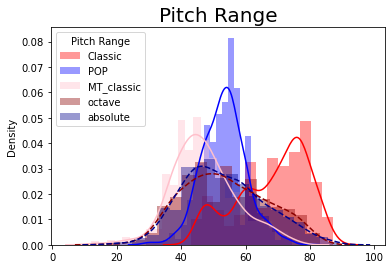

In [68]:
sns.distplot(set1_eval['pitch_range'], color='red', label='Classic')
sns.distplot(set2_eval['pitch_range'], color='blue', label='POP')
sns.distplot(set3_eval['pitch_range'], color='pink', label='MT_classic')
# sns.distplot(set4_eval['pitch_range'], color='skyblue', label='MT_POP')
sns.distplot(set5_eval['pitch_range'], color='darkred', kde_kws={'linestyle':'--'}, label='octave')
sns.distplot(set6_eval['pitch_range'], color='darkblue', kde_kws={'linestyle':'--'}, label='absolute')

# plt.xlim(20, 80)

plt.title("Pitch Range", fontsize=20)
plt.legend(title='Pitch Range', fontsize=10);
plt.savefig('Pitch_MAX.png', dpi=300)
plt.show();

/home/bang/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/bang/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/bang/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `hist

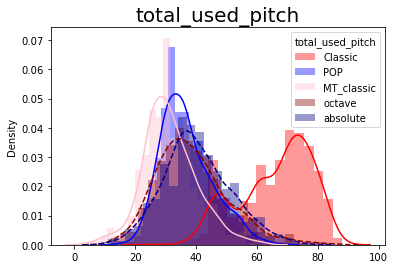

In [70]:
sns.distplot(set1_eval['total_used_pitch'], color='red', label='Classic')
sns.distplot(set2_eval['total_used_pitch'], color='blue', label='POP')
sns.distplot(set3_eval['total_used_pitch'], color='pink', label='MT_classic')
# sns.distplot(set4_eval['total_used_pitch'], color='skyblue', label='MT_POP')
sns.distplot(set5_eval['total_used_pitch'], color='darkred', kde_kws={'linestyle':'--'}, label='octave')
sns.distplot(set6_eval['total_used_pitch'], color='darkblue', kde_kws={'linestyle':'--'}, label='absolute')

# plt.xlim(10, 60)
plt.title("total_used_pitch", fontsize=20)
plt.legend(title='total_used_pitch', fontsize=10)
plt.savefig('total_used_pitch.png', dpi=300)
plt.show()

/home/bang/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/bang/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/bang/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `hist

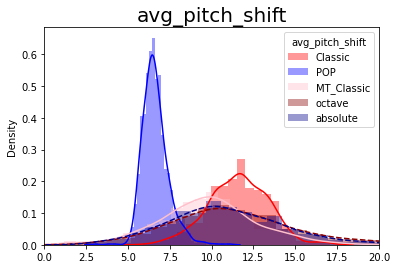

In [71]:
sns.distplot(set1_eval['avg_pitch_shift'], color='red', label='Classic')
sns.distplot(set2_eval['avg_pitch_shift'], color='blue', label='POP')
sns.distplot(set3_eval['avg_pitch_shift'], color='pink', label='MT_Classic')
# sns.distplot(set4_eval['avg_pitch_shift'], color='skyblue', label='MT_POP')
sns.distplot(set5_eval['avg_pitch_shift'], color='darkred', kde_kws={'linestyle':'--'}, label='octave')
sns.distplot(set6_eval['avg_pitch_shift'], color='darkblue', kde_kws={'linestyle':'--'}, label='absolute')

plt.xlim(0, 20)
plt.title("avg_pitch_shift", fontsize=20)
plt.legend(title='avg_pitch_shift', fontsize=10)
plt.savefig('avg_pitch_shift.png', dpi=300)
plt.show()

/home/bang/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/bang/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/bang/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `hist

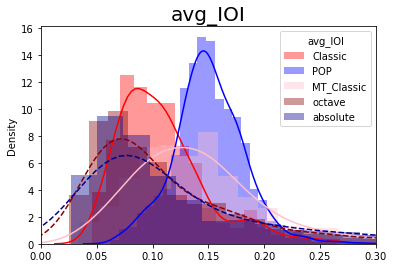

In [74]:
sns.distplot(set1_eval['avg_IOI'], color='red', label='Classic')
sns.distplot(set2_eval['avg_IOI'], color='blue', label='POP')
sns.distplot(set3_eval['avg_IOI'], color='pink', label='MT_Classic')
# sns.distplot(set4_eval['avg_IOI'], color='skyblue', label='MT_POP')
sns.distplot(set5_eval['avg_IOI'], color='darkred', kde_kws={'linestyle':'--'}, label='octave')
sns.distplot(set6_eval['avg_IOI'], color='darkblue', kde_kws={'linestyle':'--'}, label='absolute')

plt.xlim(0, 0.3)
plt.title("avg_IOI", fontsize=20)
plt.legend(title='avg_IOI', fontsize=10)
plt.savefig('avg_IOI.png', dpi=300)
plt.show()

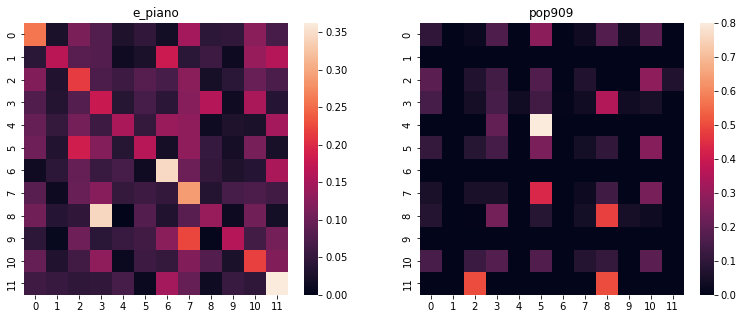

In [65]:
plt.figure(figsize=(13,5))

plt.subplot(1, 2, 1)
plt.title("e_piano")
sns.heatmap(data = set1_eval['pitch_class_transition_matrix'][80])
plt.subplot(1, 2, 2)
plt.title("pop909")
sns.heatmap(data = set2_eval['pitch_class_transition_matrix'][80])


plt.show()

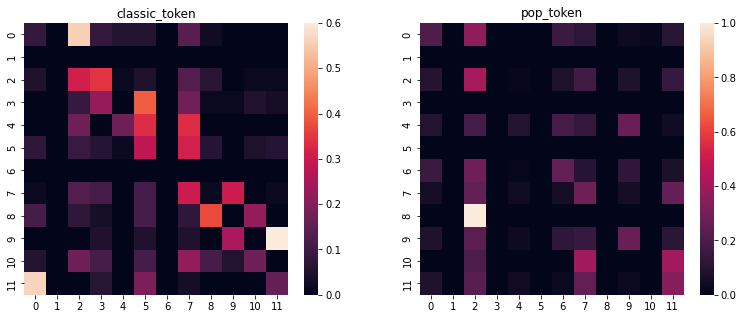

In [36]:
plt.figure(figsize=(13,5))

plt.subplot(1, 2, 1)
plt.title("classic_token")
sns.heatmap(data = set3_eval['pitch_class_transition_matrix'][80])
plt.subplot(1, 2, 2)
plt.title("pop_token")
sns.heatmap(data = set4_eval['pitch_class_transition_matrix'][80])


plt.show()